# Train Model

Train XGBoost Model (Feature Selection & Bayesian Optimisation).
Test Model Accuracy and AUC.
Test Betting Strategy on 2025 Matches.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import optuna
import pickle
from tqdm.auto import tqdm
from optuna.importance import get_param_importances
from plotly.io import show
import optuna.visualization as vis
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as mtri
pd.set_option('display.max_columns', None)

c:\Users\daraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import Final Dataset

In [3]:
final_dataset = pd.read_csv("./data/1finalDatasetOdds.csv")
cols = [col for col in final_dataset.columns if col != "RESULT"] + ["RESULT"]
final_dataset = final_dataset[cols]
final_dataset.tail(5)

,AGE_DIFF,ATP_POINTS_DIFF,ATP_RANK_DIFF,BEST_OF,CHAMPIONSHIPS_DIFF,CHAMPIONSHIPS_P1,CHAMPIONSHIPS_P2,DRAW_SIZE,ELO_GRAD_LAST_100_DIFF,ELO_GRAD_LAST_100_P1,ELO_GRAD_LAST_100_P2,ELO_GRAD_LAST_10_DIFF,ELO_GRAD_LAST_10_P1,ELO_GRAD_LAST_10_P2,ELO_GRAD_LAST_200_DIFF,ELO_GRAD_LAST_200_P1,ELO_GRAD_LAST_200_P2,ELO_GRAD_LAST_25_DIFF,ELO_GRAD_LAST_25_P1,ELO_GRAD_LAST_25_P2,ELO_GRAD_LAST_50_DIFF,ELO_GRAD_LAST_50_P1,ELO_GRAD_LAST_50_P2,ELO_GRAD_LAST_5_DIFF,ELO_GRAD_LAST_5_P1,ELO_GRAD_LAST_5_P2,H2H_DIFF,H2H_P1,H2H_P2,H2H_SURFACE_DIFF,H2H_SURFACE_P1,H2H_SURFACE_P2,HAS_PLAYED_CUR_LEVEL_P1,HAS_PLAYED_CUR_LEVEL_P2,HAS_PLAYED_CUR_ROUND_P1,HAS_PLAYED_CUR_ROUND_P2,HAS_PLAYED_CUR_TOURN_P1,HAS_PLAYED_CUR_TOURN_P2,HEIGHT_DIFF,MATCHES_LAST_1MO_P1,MATCHES_LAST_1MO_P2,MATCHES_LAST_1YR_P1,MATCHES_LAST_1YR_P2,MATCHES_LAST_3MO_P1,MATCHES_LAST_3MO_P2,MATCHES_LAST_6MO_P1,MATCHES_LAST_6MO_P2,MATCHES_PLAYED_P1,MATCHES_PLAYED_P2,N_GAMES_DIFF,P1_ELO,P1_ODDS,P1_SURFACE_ELO,P1_WINPROB,P2_ELO,P2_ODDS,P2_SURFACE_ELO,P2_WINPROB,PCT_WIN_CUR_LEVEL_P1,PCT_WIN_CUR_LEVEL_P2,PCT_WIN_CUR_ROUND_P1,PCT_WIN_CUR_ROUND_P2,PCT_WIN_CUR_TOURN_P1,PCT_WIN_CUR_TOURN_P2,P_1ST_IN_LAST_10_DIFF,P_1ST_IN_LAST_25_DIFF,P_1ST_IN_LAST_50_DIFF,P_1ST_IN_LAST_5_DIFF,P_1ST_WON_LAST_10_DIFF,P_1ST_WON_LAST_25_DIFF,P_1ST_WON_LAST_50_DIFF,P_1ST_WON_LAST_5_DIFF,P_2ND_WON_LAST_10_DIFF,P_2ND_WON_LAST_25_DIFF,P_2ND_WON_LAST_50_DIFF,P_2ND_WON_LAST_5_DIFF,P_ACE_DF_LAST_10_DIFF,P_ACE_DF_LAST_25_DIFF,P_ACE_DF_LAST_50_DIFF,P_ACE_DF_LAST_5_DIFF,P_ACE_LAST_10_DIFF,P_ACE_LAST_25_DIFF,P_ACE_LAST_50_DIFF,P_ACE_LAST_5_DIFF,P_BP/RECG_LAST_10_DIFF,P_BP/RECG_LAST_25_DIFF,P_BP/RECG_LAST_50_DIFF,P_BP/RECG_LAST_5_DIFF,P_BP_CONVERTED_LAST_10_DIFF,P_BP_CONVERTED_LAST_25_DIFF,P_BP_CONVERTED_LAST_50_DIFF,P_BP_CONVERTED_LAST_5_DIFF,P_BP_SAVED_LAST_100_DIFF,P_BP_SAVED_LAST_10_DIFF,P_BP_SAVED_LAST_200_DIFF,P_BP_SAVED_LAST_25_DIFF,P_BP_SAVED_LAST_50_DIFF,P_BP_SAVED_LAST_5_DIFF,P_DF_2ND_LAST_10_DIFF,P_DF_2ND_LAST_25_DIFF,P_DF_2ND_LAST_50_DIFF,P_DF_2ND_LAST_5_DIFF,P_DF_LAST_10_DIFF,P_DF_LAST_25_DIFF,P_DF_LAST_50_DIFF,P_DF_LAST_5_DIFF,P_SPW_LAST_10_DIFF,P_SPW_LAST_25_DIFF,P_SPW_LAST_50_DIFF,P_SPW_LAST_5_DIFF,P_TOTAL_PWON_LAST_100_DIFF,P_TOTAL_PWON_LAST_10_DIFF,P_TOTAL_PWON_LAST_200_DIFF,P_TOTAL_PWON_LAST_25_DIFF,P_TOTAL_PWON_LAST_50_DIFF,P_TOTAL_PWON_LAST_5_DIFF,ROUND,SER_WINDIFF_100_P1,SER_WINDIFF_10_P1,SER_WINDIFF_200_P1,SER_WINDIFF_25_P1,SER_WINDIFF_50_P1,SER_WINDIFF_5_P1,SET_WINDIFF_100_DIFF,SET_WINDIFF_100_P2,SET_WINDIFF_10_DIFF,SET_WINDIFF_10_P2,SET_WINDIFF_200_DIFF,SET_WINDIFF_200_P2,SET_WINDIFF_25_DIFF,SET_WINDIFF_25_P2,SET_WINDIFF_50_DIFF,SET_WINDIFF_50_P2,SET_WINDIFF_5_DIFF,SET_WINDIFF_5_P2,WIN_LAST_100_DIFF,WIN_LAST_10_DIFF,WIN_LAST_200_DIFF,WIN_LAST_25_DIFF,WIN_LAST_50_DIFF,WIN_LAST_5_DIFF,tourney_date,tourney_id,WIN_LAST_5_P1,WIN_LAST_5_P2,WIN_LAST_10_P1,WIN_LAST_10_P2,WIN_LAST_25_P1,WIN_LAST_25_P2,WIN_LAST_50_P1,WIN_LAST_50_P2,WIN_LAST_100_P1,WIN_LAST_100_P2,WIN_LAST_200_P1,WIN_LAST_200_P2,ELO_DIFF,SURFACE_ELO_DIFF,PRED_ODDS,RESULT
43273,-3.0,324.0,-17.0,5,0,0,0,128.0,0.000000,0.00000,0.000000,11.829443,13.587416,1.757973,0.0,0.0,0.0,10.512010,12.072589,1.560579,0.000000,0.000000,0.000000,20.302056,18.836923,-1.465133,0,0,0,0,0,0,1,1,1,1,1,1,15.0,3,0,21,22,7,6,14,12,27,114,-87,1951.305528,1.20,1794.505190,0.812500,1843.142555,5.20,1628.017100,0.187500,0.600000,0.450000,57.142857,37.500000,0.0,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.020439,392.593298,187.653538,201.374612,37.713351,1263.621801,R128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2,0,0,2025-06-30,540,3.0,3.0,6.0,6.0,12.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,108.162973,166.488090,1,1
43274,-3.2,-443.0,34.0,5,0,0,0,128.0,0.000000,0.00000,0.000000,19.908023,13.999478,-5.908545,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.247403,16.136662,-7.110741,0,0,0,0,0,

## Split Training vs Testing Data

Seperate 2025 data and split remaining shuffled data.

In [4]:
final_dataset['tourney_date'] = pd.to_datetime(final_dataset['tourney_date'], errors='coerce')

mask = (
    (final_dataset['tourney_date'].dt.year == 2025) |
    ((final_dataset['tourney_date'].dt.year == 2024) & (final_dataset['tourney_id'] == "339"))
)

final_2025 = final_dataset[mask].copy()
final_dataset = final_dataset[~mask].copy()

data = final_dataset.sample(frac=1)
data_2025 = final_2025.copy()


split = 0.85
value = round(split*len(data))
data_train = data.iloc[:value,:]
data_test = data.iloc[value:,:]

In [5]:
# Remove 'P1_ODDS' and 'P2_ODDS' and Tourney Data columns from data_train and test
data_train = data_train.drop(columns={'P1_ODDS', 'P2_ODDS', 'tourney_date', 'tourney_id', 'ROUND'})
data_test_odds = data_test.drop(columns={'tourney_date', 'tourney_id', 'ROUND'})
data_test = data_test.drop(columns={'P1_ODDS', 'P2_ODDS', 'tourney_date', 'tourney_id', 'ROUND'})

In [6]:
# Training data
x_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1:]

# 2025 data
x_2025 = data_2025.iloc[:,:-1]
y_2025 = data_2025.iloc[:,-1:]

# Testing data
x_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1:]

## Train Models

### Train XGBoost Algorithm

1. Baseline model

In [7]:
# Instantiate an XGBoost Classifier
xgb_model_base = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.7, eval_metric='logloss')

# Train the model
xgb_model_base.fit(x_train, y_train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Make predictions
predictions_train = xgb_model_base.predict(x_train)
predictions_test = xgb_model_base.predict(x_test)
baseline_scores = cross_val_score(xgb_model_base, x_train, y_train, cv=cv, scoring='roc_auc')
probs_test = xgb_model_base.predict_proba(x_test)[:, 1]

# Calculate accuracy
print("Train Accuracy: " + str(accuracy_score(y_train, predictions_train)))
print("Test Accuracy: " + str(accuracy_score(y_test, predictions_test)))
print("Test AUC:      ", roc_auc_score(y_test, probs_test))
print("Per‐fold AUCs:      ", baseline_scores)
print("Mean CV AUC:        ", np.mean(baseline_scores))
print("Std. dev. of AUCs:  ", np.std(baseline_scores))

Train Accuracy: 0.9999447406957146
Test Accuracy: 0.7294504462188821
Test AUC:       0.8017987082325417
Per‐fold AUCs:       [0.8115868  0.80402924 0.80698607 0.80639721 0.80518663]
Mean CV AUC:         0.806837190968524
Std. dev. of AUCs:   0.0025839311451346567


2. Feature Selection on top 20% of features (by importance)

In [8]:
model = XGBClassifier(
    n_estimators=200, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.7,
    eval_metric='logloss',
    n_jobs=-1
)
model.fit(x_train, y_train)

# 80th percentile selector
importances = model.feature_importances_
p80 = np.percentile(importances, 80)

sfm = SelectFromModel(
    estimator=model,
    threshold=p80,
    prefit=True
)

# Collect selected features
mask = sfm.get_support()
selected_features = x_train.columns[mask]

print("Features before:", x_train.shape[1])
print("Keeping top 20% by importance →", len(selected_features), "features:")
print(selected_features.tolist())

# Extract relevant columns from dataframes
X_train_sfm = x_train[selected_features].copy()
X_test_sfm  = x_test [selected_features].copy()

print("Features after: ", X_train_sfm.shape[1])

model.fit(X_train_sfm, y_train)
print("Test AUC (reduced):",
      roc_auc_score(y_test,
                    model.predict_proba(X_test_sfm)[:,1]))

# Save Features
with open('./Training/Features/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features.tolist(), f)


Features before: 153
Keeping top 20% by importance → 31 features:
['ATP_POINTS_DIFF', 'CHAMPIONSHIPS_P2', 'ELO_GRAD_LAST_200_DIFF', 'ELO_GRAD_LAST_200_P1', 'ELO_GRAD_LAST_5_DIFF', 'ELO_GRAD_LAST_5_P1', 'ELO_GRAD_LAST_5_P2', 'H2H_SURFACE_DIFF', 'HAS_PLAYED_CUR_LEVEL_P2', 'HAS_PLAYED_CUR_TOURN_P1', 'HAS_PLAYED_CUR_TOURN_P2', 'MATCHES_LAST_1MO_P1', 'MATCHES_LAST_1MO_P2', 'MATCHES_LAST_3MO_P1', 'MATCHES_LAST_3MO_P2', 'MATCHES_PLAYED_P2', 'N_GAMES_DIFF', 'P1_WINPROB', 'P2_WINPROB', 'PCT_WIN_CUR_TOURN_P1', 'PCT_WIN_CUR_TOURN_P2', 'WIN_LAST_100_DIFF', 'WIN_LAST_50_DIFF', 'WIN_LAST_5_DIFF', 'WIN_LAST_5_P1', 'WIN_LAST_5_P2', 'WIN_LAST_200_P1', 'WIN_LAST_200_P2', 'ELO_DIFF', 'SURFACE_ELO_DIFF', 'PRED_ODDS']
Features after:  31
Test AUC (reduced): 0.8020561007919846


3. Bayesion Optimisation (5 Fold)

In [ ]:
X_red = X_train_sfm
y_red = y_train

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Outline hyperparameters
def objective(trial):
    params = {
        'n_estimators':     trial.suggest_int   ('n_estimators',     50, 800),
        'max_depth':        trial.suggest_int   ('max_depth',         3,   10),
        'learning_rate':    trial.suggest_float ('learning_rate',  1e-3, 1e-1, log=True),
        'subsample':        trial.suggest_float ('subsample',       0.5,   1.0),
        'colsample_bytree': trial.suggest_float ('colsample_bytree',0.5,   1.0),
        'reg_alpha':        trial.suggest_float ('reg_alpha',      1e-3,  10.0, log=True),
        'reg_lambda':       trial.suggest_float ('reg_lambda',     1e-3,  10.0, log=True),
        'use_label_encoder': False,
        'eval_metric':       'logloss',
        'tree_method':      'hist',
        'n_jobs':           -1
    }

    model = XGBClassifier(**params)

    scores = cross_val_score(
        model,
        X_red,
        y_red,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    return scores.mean()

# Create study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(),
    pruner = optuna.pruners.MedianPruner(),
    study_name="xgb_tune",
    storage="sqlite:///optuna_xgb_kfold.db",
    load_if_exists=False
)

# Find best trial
study.optimize(objective, n_trials=200)

print("Best CV AUC:     ", study.best_value)
print("Best hyperparams:", study.best_params)

# Retrain on full reduced set
final_model = XGBClassifier(**study.best_params, 
                            use_label_encoder=False,
                            eval_metric='logloss',
                            tree_method='hist',
                            skip_if_exists=True,
                            n_jobs=-1)
final_model.fit(X_red, y_red)

# Save Model
final_model.save_model("./models/final_model.json")


[I 2025-08-01 15:35:45,374] A new study created in RDB with name: xgb_tune_1
[I 2025-08-01 15:36:05,989] Trial 0 finished with value: 0.8077065317988048 and parameters: {'n_estimators': 558, 'max_depth': 6, 'learning_rate': 0.001725600954675553, 'subsample': 0.702692929370996, 'colsample_bytree': 0.6185919198499026, 'reg_alpha': 0.0010663653254333527, 'reg_lambda': 0.05022653310407617}. Best is trial 0 with value: 0.8077065317988048.
[I 2025-08-01 15:36:18,705] Trial 1 finished with value: 0.8185793381607803 and parameters: {'n_estimators': 391, 'max_depth': 5, 'learning_rate': 0.010224184276424304, 'subsample': 0.8581423749005054, 'colsample_bytree': 0.874677586235172, 'reg_alpha': 0.01542819772593164, 'reg_lambda': 0.20002097532295768}. Best is trial 1 with value: 0.8185793381607803.
[I 2025-08-01 15:36:42,606] Trial 2 finished with value: 0.8137980213298656 and parameters: {'n_estimators': 318, 'max_depth': 10, 'learning_rate': 0.006811777311457634, 'subsample': 0.6590399086965517, 

Best CV AUC:      0.8255178678065331
Best hyperparams: {'n_estimators': 799, 'max_depth': 5, 'learning_rate': 0.015782049823617274, 'subsample': 0.872520989922265, 'colsample_bytree': 0.9103516814868841, 'reg_alpha': 4.181409214059093, 'reg_lambda': 0.13597451462444632}


c:\Users\daraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:53:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "skip_if_exists", "use_label_encoder" } are not used.




Test AUC: 0.825255295805553


In [14]:
study = optuna.load_study(study_name="xgb_tune", storage="sqlite:///optuna_xgb_kfold.db")
final_model = XGBClassifier(**study.best_params, 
                            use_label_encoder=False,
                            eval_metric='logloss',
                            tree_method='hist',
                            skip_if_exists=True,
                            n_jobs=-1)
final_model.fit(X_train_sfm, y_train)

# Save Model
final_model.save_model("./models/final_model.json")

c:\Users\daraj\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[13:11:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "skip_if_exists", "use_label_encoder" } are not used.




4. Identify most important features for model interprentation

Selected feature importances (most → least):

PRED_ODDS                  0.665005
P2_WINPROB                 0.015527
P1_WINPROB                 0.015313
HAS_PLAYED_CUR_TOURN_P1    0.012779
HAS_PLAYED_CUR_TOURN_P2    0.011413
ELO_DIFF                   0.006763
MATCHES_LAST_1MO_P2        0.005389
MATCHES_LAST_1MO_P1        0.004919
HAS_PLAYED_CUR_LEVEL_P2    0.002942
WIN_LAST_5_P1              0.002838
WIN_LAST_5_DIFF            0.002814
H2H_SURFACE_DIFF           0.002680
ELO_GRAD_LAST_5_DIFF       0.002573
WIN_LAST_5_P2              0.002546
PCT_WIN_CUR_TOURN_P1       0.002524
ELO_GRAD_LAST_200_DIFF     0.002516
ATP_POINTS_DIFF            0.002507
ELO_GRAD_LAST_5_P2         0.002458
CHAMPIONSHIPS_P2           0.002439
MATCHES_PLAYED_P2          0.002413
PCT_WIN_CUR_TOURN_P2       0.002409
MATCHES_LAST_3MO_P2        0.002384
WIN_LAST_200_P2            0.002378
N_GAMES_DIFF               0.002375
WIN_LAST_100_DIFF          0.002365
ELO_GRAD_LAST_5_P1         0.002347
WIN_LAST_50_DIFF  

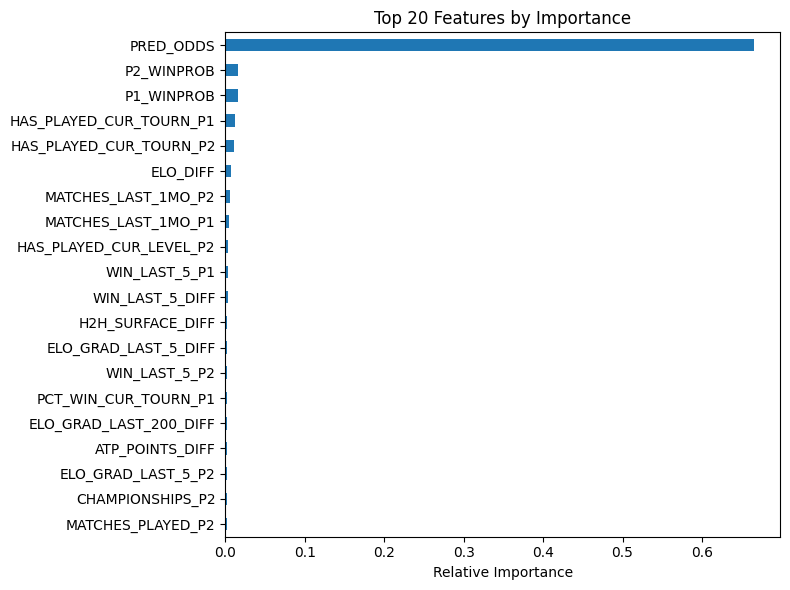

In [9]:
# 5) Grab the importances of just those selected features
selected_importances = importances[mask]

# 6) Build & sort a Series
feat_imp = pd.Series(selected_importances, index = selected_features)
feat_imp = feat_imp.sort_values(ascending=False)

# 7) View the full ranking
print("Selected feature importances (most → least):\n")
print(feat_imp)

# 8) (Optional) Plot the top 20
plt.figure(figsize=(8,6))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Importance")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


### Test Model on test set

In [15]:
X_test_red = X_test_sfm
y_test_num = y_test

final_model = XGBClassifier()
final_model.load_model("./models/final_model.json")

probs = final_model.predict_proba(X_test_red)[:,1]
pred = final_model.predict(X_test_red)
print("Test Accuracy: ", accuracy_score(y_test_num, pred))
print("Test AUC:", roc_auc_score(y_test_num, probs))

Test Accuracy:  0.7324252387662439
Test AUC: 0.8110853337229358


### Test Betting Strategy

Strategy      | Bets | Wins | Losses |   ROI   | Pred Edge ±σ | Real Edge ±σ |   Profit   |
------------------------------------------------------------------------------------------
ev_kelly      |  176 |  134 |     42 |  56.59% | 0.4715±0.3482 | 0.5634±1.0171 |    9695.20 |

ROI by model-prob threshold:
   prob_thr  bets       ROI
0      0.50   445  0.254138
1      0.55   413  0.251928
2      0.60   380  0.230517
3      0.65   337  0.255373
4      0.70   274  0.236005
5      0.75   215  0.217432
6      0.80   154  0.209003
7      0.85    95  0.220751
8      0.90    39  0.142244

ROI by EV threshold:
      ev_thr  bets       ROI
0   0.000000   445  0.254138
1   0.262435   131  0.699493
2   0.524870    46  0.977216
3   0.787305    23  1.403419
4   1.049740    10  2.042622
5   1.312175     6  2.343599
6   1.574610     3  1.992322
7   1.837045     3  1.992322
8   2.099480     1  4.020000
9   2.361915     1  4.020000
10  2.624351     1  4.020000


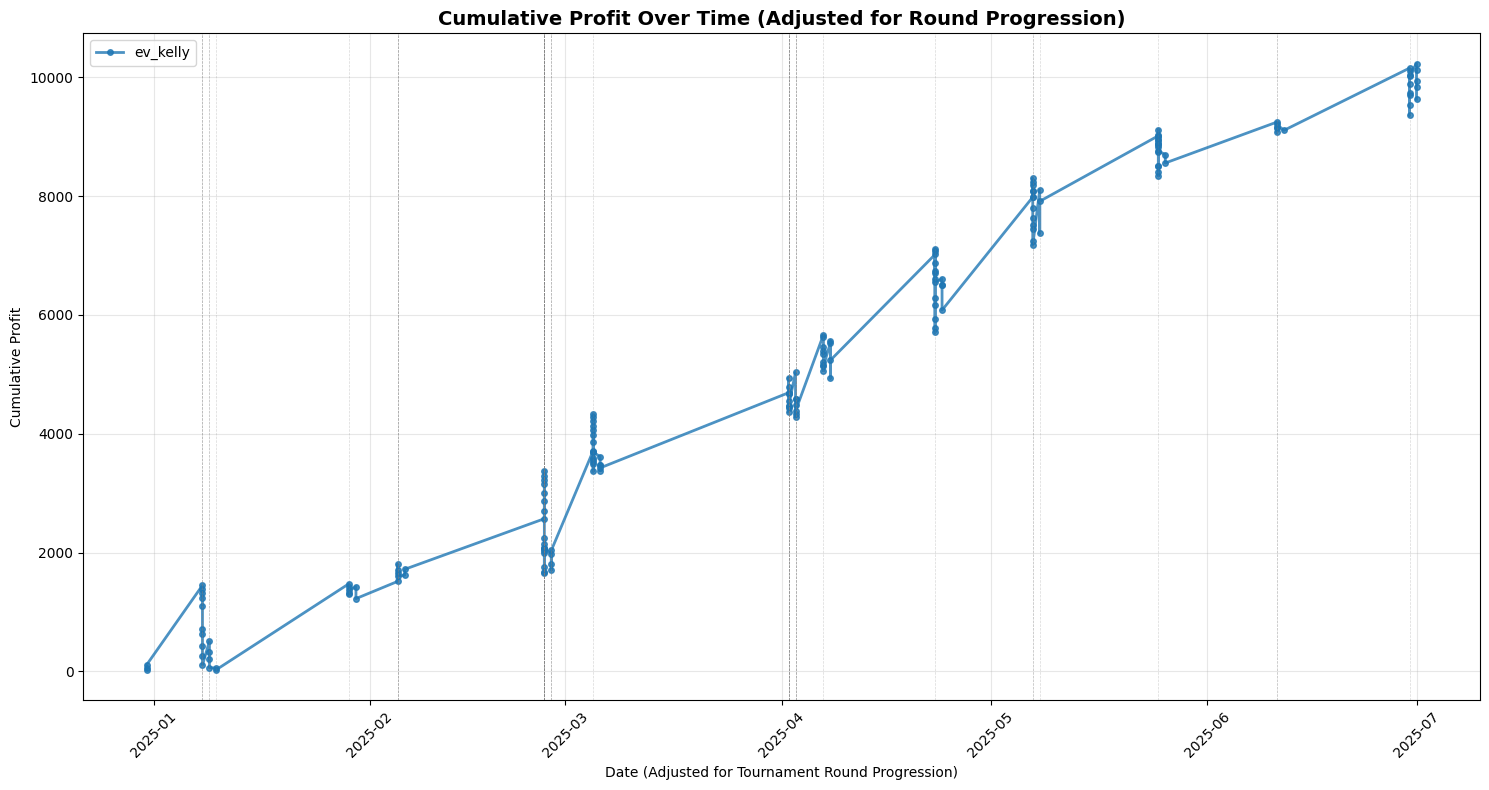

Overall MC: 100%|██████████| 500/500 [00:08<00:00, 57.35run/s, ev_kelly: 500/500]


RISK ANALYSIS
Strategy      | Bust Probability
--------------------------------
ev_kelly      | 0.00%


In [ ]:
meta_cols = ['tourney_date', 'tourney_id', 'ROUND']
X_2025_sfm = data_2025[selected_features].copy()


# Compute model probabilities
probs = final_model.predict_proba(X_2025_sfm)
pred = final_model.predict(X_2025_sfm)

# Prepare Output Dataframe
test_df = data_2025.copy()
test_df["pred"] = pred
test_df["pred_prob_p1"] = probs[:, 1]
test_df["pred_prob_p2"] = probs[:, 0]

test_df["chosen_side"] = np.where(
    test_df["pred"] == 1, "P1", "P2"
)
test_df["chosen_prob"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["pred_prob_p1"], 
    test_df["pred_prob_p2"]
)
test_df["chosen_odds"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["P1_ODDS"], 
    test_df["P2_ODDS"]
)

# Compute EV and bet outcome
test_df["EV"] = test_df["chosen_odds"] * test_df["chosen_prob"] - 1.0
test_df["b"]  = test_df["chosen_odds"] - 1.0
test_df["q"]  = 1.0 - test_df["chosen_prob"]
test_df["actual_chosen"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["RESULT"], 
    1 - test_df["RESULT"]
)

# Kelly Criterion based Stake Size
def kelly_stake(row, bankroll=100.0, fraction=0.25, **kwargs):
    p, b, q = row["chosen_prob"], row["b"], row["q"]
    f = (b*p - q) / b if b > 0 else 0.0
    return max(0.0, f) * bankroll * fraction

# Simulate Strategy Implementation
def simulate_sequential(df, stake_func, stake_kwargs=None, 
                        selection_rule=lambda d: d.index, 
                        bankroll_start=1.0):
    df = df.copy().reset_index(drop=True)
    stake_kwargs = stake_kwargs or {}

    sel = selection_rule(df)
    df = df.loc[sel].reset_index(drop=True)

    stakes, profits, bankrolls, cum_profits = [], [], [], []
    bankroll = 500
    cum_profit = 0.0

    for _, row in df.iterrows():
        # compute stake using the *current* bankroll
        stake = stake_func(row, bankroll=bankroll, **stake_kwargs)
        stake = min(stake, 00)
        # compute profit
        profit = row["b"] * stake if row["actual_chosen"] == 1 else -stake
        # update bankroll
        bankroll += profit
        bankroll = min(bankroll, 10000)
        cum_profit += profit

        # record
        stakes.append(stake)
        profits.append(profit)
        bankrolls.append(bankroll)
        cum_profits.append(cum_profit)

    # assign back to DataFrame
    df["stake"]    = stakes
    df["profit"]   = profits
    df["bankroll"] = bankrolls
    df["cum_profit"] = cum_profits

    bet_df = df[df["stake"] > 0].copy()

    total_profit = bet_df["profit"].sum()
    total_staked = bet_df["stake"].sum()
    roi = total_profit / total_staked if total_staked > 0 else float("nan")
    
    # count wins & losses
    wins   = int((bet_df["profit"] > 0).sum())
    losses = int((bet_df["profit"] <= 0).sum())
    
    mean_pred_edge = bet_df["EV"].mean()
    std_pred_edge  = bet_df["EV"].std()
    
    # record realized edge for analysis
    bet_df["realized_edge"] = bet_df["profit"]/bet_df["stake"]
    mean_real_edge = bet_df["realized_edge"].mean()
    std_real_edge  = bet_df["realized_edge"].std()

    return {
        "df": bet_df,
        "bets": len(bet_df),
        "wins": wins,
        "losses": losses,
        "profit": total_profit,
        "ROI": roi,
        "mean_pred_edge": mean_pred_edge,
        "std_pred_edge": std_pred_edge,
        "mean_real_edge": mean_real_edge,
        "std_real_edge": std_real_edge
    }

sel_ev  = lambda d: d[d["EV"] >= 0.2].index

results = {
    "ev_kelly":     simulate_sequential(test_df, kelly_stake, {"fraction":0.25}, sel_ev),
}

print("Strategy      | Bets | Wins | Losses |   ROI   | Pred Edge ±σ | Real Edge ±σ |   Profit   |")
print("------------------------------------------------------------------------------------------")
for name, r in results.items():
    print(f"{name:13s} | {r['bets']:4d} | {r['wins']:4d} | {r['losses']:6d} |"
          f" {r['ROI']:7.2%} |"
          f" {r['mean_pred_edge']:.4f}±{r['std_pred_edge']:.4f} |"
          f" {r['mean_real_edge']:.4f}±{r['std_real_edge']:.4f}"
          f" | {r['profit']:10.2f} |")

# Breakdown by probability thresholds
prob_thrs = np.linspace(0.5, 0.9, 9)
prob_break = []
for thr in prob_thrs:
    sub = test_df[test_df["chosen_prob"] >= thr]
    if sub.empty: continue
    res = simulate_sequential(sub, kelly_stake, {"stake_size":1.0}, lambda d: d.index)
    prob_break.append((thr, res["bets"], res["ROI"]))
prob_df = pd.DataFrame(prob_break, columns=["prob_thr","bets","ROI"])
print("\nROI by model-prob threshold:")
print(prob_df)

# Breakdown by EV thresholds
ev_thrs = np.linspace(0, test_df["EV"].max(), 11)
ev_break = []
for thr in ev_thrs:
    sub = test_df[test_df["EV"] >= thr]
    if sub.empty: continue
    res = simulate_sequential(sub, kelly_stake, {"stake_size":1.0}, lambda d: d.index)
    ev_break.append((thr, res["bets"], res["ROI"]))
ev_df = pd.DataFrame(ev_break, columns=["ev_thr","bets","ROI"])
print("\nROI by EV threshold:")
print(ev_df)

# Function to adjust dates based on tournament rounds
def adjust_dates_by_round(df):
    """
    Adjust dates so that within each tournament, rounds progress sequentially by day.
    Round progression: R128 → R64 → R32 → R16 → QF → SF → F → RR
    """
    df = df.copy()
    
    # Define round order and their day offsets
    round_order = {
        'R128': 0,
        'R64': 1, 
        'R32': 2,
        'R16': 3,
        'QF': 4,
        'SF': 5,
        'F': 6,
        'RR': 7  # Place RR at the end, though it can vary by tournament
    }
    
    # Convert tourney_date to datetime if it isn't already
    df['tourney_date'] = pd.to_datetime(df['tourney_date'])
    
    # Create adjusted date column
    df['adjusted_date'] = df['tourney_date']
    
    # For each tournament, adjust dates based on round
    for tourney_id in df['tourney_id'].unique():
        tourney_mask = df['tourney_id'] == tourney_id
        tourney_data = df[tourney_mask]
        
        # Get the base date for this tournament (earliest date)
        base_date = tourney_data['tourney_date'].min()
        
        # Adjust dates for each round
        for idx in tourney_data.index:
            round_name = df.loc[idx, 'ROUND']
            if round_name in round_order:
                day_offset = round_order[round_name]
                df.loc[idx, 'adjusted_date'] = base_date + pd.Timedelta(days=day_offset)
            else:
                # Keep original date for unknown rounds
                df.loc[idx, 'adjusted_date'] = df.loc[idx, 'tourney_date']
    
    return df

# Plot Profit/Loss with Round-Adjusted Time Progression
plt.figure(figsize=(15, 8))

for name, r in results.items():
    df_plot = r['df']
    if df_plot.empty:
        continue
    
    df_plot = adjust_dates_by_round(df_plot)
    
    df_plot = df_plot.sort_values('adjusted_date')
    
    plt.plot(
        df_plot['adjusted_date'], 
        df_plot['cum_profit'], 
        marker='o', 
        linestyle='-', 
        label=f'{name}',
        linewidth=2,
        markersize=4,
        alpha=0.8
    )
    
    prev_tourney = None
    for idx, row in df_plot.iterrows():
        if prev_tourney is not None and prev_tourney != row['tourney_id']:
            plt.axvline(x=row['adjusted_date'], color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
        prev_tourney = row['tourney_id']

plt.title('Cumulative Profit Over Time (Adjusted for Round Progression)', fontsize=14, fontweight='bold')
plt.xlabel('Date (Adjusted for Tournament Round Progression)')
plt.ylabel('Cumulative Profit')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Run sequential simulation and report minimum bankroll
def min_bankroll(df, stake_func, stake_kwargs, selection_rule, bankroll_start):
    res = simulate_sequential(df, stake_func, stake_kwargs, selection_rule, bankroll_start)
    return res["df"]["bankroll"].min()

# Monte-Carlo estimate of bust probability
def estimate_bust_prob(df, stake_func, stake_kwargs, selection_rule,
                       bankroll_start=1.0, runs=1000, seed=42):
    rng = np.random.default_rng(seed)
    busts = 0
    for _ in tqdm(range(runs), desc="MC runs", position=1, unit="run"):
        df_run = df.sample(frac=1, random_state=rng.integers(1e9))
        if min_bankroll(df_run, stake_func, stake_kwargs, selection_rule, bankroll_start) <= 0:
            busts += 1
    return busts / runs

strategies = [
    ("ev_kelly",     kelly_stake, {"fraction":1.0},  sel_ev),
]
runs = 500
total_runs = runs * len(strategies)

bust_results = {}

pbar = tqdm(total=total_runs, desc="Overall MC", unit="run")

for name, fn, kwargs, rule in strategies:
    busts = 0
    for i in range(runs):
        pbar.set_postfix_str(f"{name}: {i+1}/{runs}")
        
        df_run = test_df.sample(frac=1, random_state=None).reset_index(drop=True)
        if min_bankroll(df_run, fn, kwargs, rule, bankroll_start=1.0) <= 0:
            busts += 1
        
        pbar.update(1)
    
    bust_results[name] = busts / runs

pbar.close()

print("\n" + "="*40)
print("RISK ANALYSIS")
print("="*40)
print("Strategy      | Bust Probability")
print("--------------------------------")
for name, p in bust_results.items():
    print(f"{name:13s} | {p:.2%}")

Compare Model Accuracy to Odds, Elo, Rank.

In [38]:
test_df["CHOSEN"] = np.where(test_df["chosen_side"] == "P1",
                            1, 0)
accuracy = (test_df["CHOSEN"] == test_df["RESULT"]).mean()
print(f"Model odds prediction accuracy: {accuracy:.3%}")

accuracy = (test_df["PRED_ODDS"] == test_df["RESULT"]).mean()
print(f"Betting odds prediction accuracy: {accuracy:.3%}")

test_df["ELO_CHOSEN"] = np.where(test_df["P1_ELO"] >= test_df["P2_ELO"], 1, 0)
accuracy = (test_df["ELO_CHOSEN"] == test_df["RESULT"]).mean()
print(f"Elo prediction accuracy: {accuracy:.3%}")

test_df["ATP_CHOSEN"] = np.where(test_df["ATP_POINTS_DIFF"] >= 0, 1, 0)
accuracy = (test_df["ATP_CHOSEN"] == test_df["RESULT"]).mean()
print(f"ATP Points prediction accuracy: {accuracy:.3%}")


Model odds prediction accuracy: 70.630%
Betting odds prediction accuracy: 66.046%
Elo prediction accuracy: 61.748%
ATP Points prediction accuracy: 62.321%
